## DS 5110 Final Project - Hospital Mortality
### By: Elena Tsvetskova, Brian Chae, Ryan Viti (rrv7eb)

In [33]:
# importing necessary libraries and packages
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, isnan, when, count, countDistinct
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation

# session initialization
spark = SparkSession.builder \
        .master("local") \
        .appName("Team 3 Final Project") \
        .getOrCreate()

filename = "hospital_mortality.csv"

data = spark.read.csv(filename, inferSchema=True, header=True)
data.count()

91713

In [34]:
# printing original dataset schema
data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache

## Data Cleaning and EDA

In [35]:
# empty columns and unique identifiers unnecessary for analysis

data = data.drop("_c83", "encounter_id", "patient_id", "hospital_id", "icu_id", "icu_stay_type")

In [36]:
# numeric distribution of diseases
diseases = ["aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "leukemia", "lymphoma", "solid_tumor_with_metastasis"]
for i in diseases:
    data.select(i).groupBy(i).count().show()

+----+-----+
|aids|count|
+----+-----+
|null|  715|
|   1|   78|
|   0|90920|
+----+-----+

+---------+-----+
|cirrhosis|count|
+---------+-----+
|     null|  715|
|        1| 1428|
|        0|89570|
+---------+-----+

+-----------------+-----+
|diabetes_mellitus|count|
+-----------------+-----+
|             null|  715|
|                1|20492|
|                0|70506|
+-----------------+-----+

+---------------+-----+
|hepatic_failure|count|
+---------------+-----+
|           null|  715|
|              1| 1182|
|              0|89816|
+---------------+-----+

+--------+-----+
|leukemia|count|
+--------+-----+
|    null|  715|
|       1|  643|
|       0|90355|
+--------+-----+

+--------+-----+
|lymphoma|count|
+--------+-----+
|    null|  715|
|       1|  376|
|       0|90622|
+--------+-----+

+---------------------------+-----+
|solid_tumor_with_metastasis|count|
+---------------------------+-----+
|                       null|  715|
|                          1| 1878|
|        

In [37]:
for name in diseases:
    data = data.withColumn(name, col(name).cast('boolean'))

In [38]:
#Address null values in dataset

data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-------------

In [39]:
# dropping noninvasive measurements due to high frequency of NA and lower accuracy of measurement
condition = lambda col: 'noninvasive' in col
data = data.drop(*filter(condition, data.columns))
len(data.columns)

67

In [40]:
imputer = Imputer()

In [41]:
# Potential correlation matrix creation using pyspark.ml.stat.Correlation here for numeric variables

In [42]:
#Drop NULL values

cleaned_data_2 = data.dropna()
cleaned_data_2.count()
# cleaned_data_2.select([count(when(col(c).isNull(), c)).alias(c) for c in cleaned_data_2.columns]).show()

60265

In [43]:
#Address null values in dataset

# Invasive vs. noninvasive measurements NA counts

# cleaned_data_2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cleaned_data_2.columns[24:56]]).show()

In [44]:
dropped_NAs = data.count() - cleaned_data_2.count()
print("Number of NAs dropped: {}".format(dropped_NAs))

Number of NAs dropped: 31448


In [45]:
# load pyspark modules
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer

#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in cleaned_data_2.dtypes if item[1].startswith('string') ]

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the stages list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(cleaned_data_2)
#transform the dataframe
df= pipelineModel.transform(cleaned_data_2)
df.take(2)

[Row(age=68, bmi=22.73, elective_surgery=0, ethnicity='Caucasian', gender='M', height=180.3, icu_admit_source='Floor', icu_type='CTICU', pre_icu_los_days=0.541666667, weight=73.9, apache_2_diagnosis=113, apache_3j_diagnosis=502.01, apache_post_operative=0, arf_apache=0, gcs_eyes_apache=3, gcs_motor_apache=6, gcs_unable_apache=0, gcs_verbal_apache=4, heart_rate_apache=118, intubated_apache=0, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, d1_potassium_max=

In [46]:
df_2 = df.drop("ethnicity", "gender", "icu_admit_source", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem")
df_2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: integer (nullable = true)
 |-- d1_diasbp_max: integer (nullable = true)
 |-- d1_diasbp_min: integer

In [47]:
#feature_columns = df_2.select([c for c in df_2.columns if c not in {'hospital_death'}])
#feature_columns.take(1)

va = VectorAssembler(inputCols=[c for c in df_2.columns if c not in {'hospital_death'}], outputCol="features")  
output = va.transform(df_2)
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(output)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(output)
df_scaled.take(5)

[Row(age=68, bmi=22.73, elective_surgery=0, height=180.3, pre_icu_los_days=0.541666667, weight=73.9, apache_2_diagnosis=113, apache_3j_diagnosis=502.01, apache_post_operative=0, arf_apache=0, gcs_eyes_apache=3, gcs_motor_apache=6, gcs_unable_apache=0, gcs_verbal_apache=4, heart_rate_apache=118, intubated_apache=0, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, d1_potassium_max=4.0, d1_potassium_min=3.4, apache_4a_hospital_death_prob=0.1, apache_4a_icu_dea

In [48]:
# Subsetting data by type of data for EDA purposes
#integer_data = data.select([data.dtypes[i][0] for i in range(len(data.dtypes)) if (data.dtypes[i][1] == 'int') and (data.select(data[i]).distinct().count() >= 10)])

#for i in integer_data.columns:
#    integer_data.describe(i).show()
#    integer_data.select(F.percentile_approx(i, [0.25, 0.75], 100000).alias("quantiles")).show()

In [49]:
# hospital_deaths = data.select("hospital_death").filter(col("hospital_death")==1 | col("hospital_death")).groupBy("hospital_death").count()
# hospital_deaths = hospital_deaths.withColumn('percent', )
# hospital_deaths.show()

In [50]:
# data.hospital_deaths.show()

In [51]:
# data.select("hospital_death").show()

### Principal Component Analysis (PCA)

In [52]:
from pyspark.ml.feature import PCA

# PCA using 4 components
pca = PCA(k=6, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_scaled)

# extract the transformed features
result = model.transform(df_scaled)

result.take(1)

[Row(age=68, bmi=22.73, elective_surgery=0, height=180.3, pre_icu_los_days=0.541666667, weight=73.9, apache_2_diagnosis=113, apache_3j_diagnosis=502.01, apache_post_operative=0, arf_apache=0, gcs_eyes_apache=3, gcs_motor_apache=6, gcs_unable_apache=0, gcs_verbal_apache=4, heart_rate_apache=118, intubated_apache=0, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, d1_potassium_max=4.0, d1_potassium_min=3.4, apache_4a_hospital_death_prob=0.1, apache_4a_icu_dea

In [53]:
import numpy as np

np.round(100.00*model.explainedVariance.toArray(),4)

array([11.205 ,  8.2298,  6.5312,  5.4657,  3.9366,  3.5679])

In [54]:
result_pca_features = result.select("pcaFeatures")
result_pca_features.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------+
|[-1.8428116851670566,-2.0107071117580344,-2.1933402726882085,0.9041213245385462,1.6405122848656477,-0.8087154799883086] |
|[-4.083352460384434,-4.861613706242349,1.5887561419087504,-2.562420096710107,0.9040013393144372,-0.7434001751787164]    |
|[-2.663286103142752,1.7895874968987102,2.0529227903971927,2.556284436361788,-0.15939962491140874,0.268640169790231]     |
|[4.0292079232430735,0.40892998255208013,-0.3438502370907018,0.23922304197112756,0.6395886140004559,0.3327860221702241]  |
|[4.356283581530569,-1.1150129908125497,1.6863345447164677,-0.5539201469798868,2.158842793223088,2.4145636391420333]     |
|[-0.28006831110

In [55]:
import pandas as pd

cols = df_2.drop('hospital_death').columns
cols

pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], index = cols)
df_pc

,PC1,PC2,PC3,PC4,PC5,PC6
age,-0.0439,0.0372,0.0462,-0.1526,0.1162,-0.0176
bmi,0.0213,-0.0046,0.0193,-0.0066,0.3392,0.0919
elective_surgery,-0.0632,0.1815,0.1506,0.3069,0.1716,0.0265
height,0.0332,0.0189,0.0332,0.0368,0.1458,0.1668
pre_icu_los_days,-0.0404,-0.0124,0.0206,0.0794,0.0790,0.0354
...,...,...,...,...,...,...
genderIndex,-0.0275,-0.0255,-0.0367,-0.0253,-0.1348,-0.1773
icu_admit_sourceIndex,-0.0360,0.0206,0.0222,0.0966,0.1372,0.0069
icu_typeIndex,-0.0255,0.0948,0.0884,0.0571,0.1146,0.0670
apache_3j_bodysystemIndex,0.0355,0.0150,-0.0210,0.1991,-0.1563,-0.1877


In [56]:
pc1 = df_pc.loc[:,'PC1'].abs().sort_values(ascending=False)
s1 = pc1[pc1 > 0.2]
s1

h1_mbp_min       0.3170
h1_sysbp_min     0.2970
h1_mbp_max       0.2927
h1_diasbp_min    0.2903
h1_sysbp_max     0.2743
d1_mbp_min       0.2611
h1_diasbp_max    0.2589
d1_sysbp_min     0.2535
d1_mbp_max       0.2404
d1_diasbp_min    0.2401
d1_sysbp_max     0.2325
map_apache       0.2143
Name: PC1, dtype: float64

In [68]:
s1index=s1.index
s1list = list(s1index)
s1list

['h1_mbp_min',
 'h1_sysbp_min',
 'h1_mbp_max',
 'h1_diasbp_min',
 'h1_sysbp_max',
 'd1_mbp_min',
 'h1_diasbp_max',
 'd1_sysbp_min',
 'd1_mbp_max',
 'd1_diasbp_min',
 'd1_sysbp_max',
 'map_apache']

In [69]:
pc2 = df_pc.loc[:,'PC2'].abs().sort_values(ascending=False)
s2 = pc2[pc2 > 0.2]
s2

h1_heartrate_max                 0.3053
d1_heartrate_max                 0.3047
heart_rate_apache                0.2798
h1_heartrate_min                 0.2789
h1_resprate_max                  0.2240
apache_4a_hospital_death_prob    0.2125
apache_4a_icu_death_prob         0.2013
Name: PC2, dtype: float64

In [71]:
s2index=s2.index
s2index

Index(['h1_heartrate_max', 'd1_heartrate_max', 'heart_rate_apache',
       'h1_heartrate_min', 'h1_resprate_max', 'apache_4a_hospital_death_prob',
       'apache_4a_icu_death_prob'],
      dtype='object')

In [72]:
pc3 = df_pc.loc[:,'PC3'].abs().sort_values(ascending=False)
s3 = pc3[pc3 > 0.2]
s3

gcs_eyes_apache                  0.3003
gcs_motor_apache                 0.2968
gcs_verbal_apache                0.2953
ventilated_apache                0.2638
intubated_apache                 0.2464
apache_4a_icu_death_prob         0.2138
d1_temp_min                      0.2127
apache_4a_hospital_death_prob    0.2064
Name: PC3, dtype: float64

In [73]:
s3index=s3.index
s3index

Index(['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache',
       'ventilated_apache', 'intubated_apache', 'apache_4a_icu_death_prob',
       'd1_temp_min', 'apache_4a_hospital_death_prob'],
      dtype='object')

In [74]:
#Union the series indices

important_vars = s3index.union(s2index).union(s1index)
list(important_vars)

['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'heart_rate_apache',
 'intubated_apache',
 'map_apache',
 'ventilated_apache']

### Experimenting with NA Origins for Certain Columns

In [75]:
import matplotlib.pyplot as plt
num_nulls_df=data.withColumn('numNulls', sum(data[col].isNull().cast('int') for col in data.columns))
# num_nulls_df.filter([data[i].isNull()==False for i in s1list]).show()
# num_nulls_df.filter([col(i).isNull()==False for i in s1list])
less_nulls_df = num_nulls_df.filter(col('h1_mbp_min').isNotNull())
# less_nulls = less_nulls.filter(less_nulls.numNulls < 3)
# less_nulls.count()
x = range(1,11)
y = []
for i in range(1, 11):
    y.append(less_nulls_df.filter(less_nulls_df.numNulls < i).count())
# less_nulls_df = num_nulls_df.filter((num_nulls_df.numNulls < 2) and col('h1_mbp_min').isNotNull())
# less_nulls_df.count()

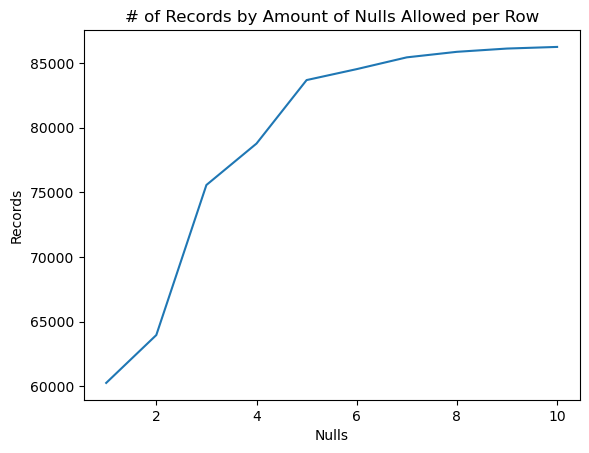

In [76]:
plt.title('# of Records by Amount of Nulls Allowed per Row')
plt.xlabel('Nulls')
plt.ylabel('Records')
plt.plot(x, y)
plt.show()

In [77]:
less_nulls_df = less_nulls_df.filter(less_nulls_df.numNulls < 3)
less_nulls_df = less_nulls_df.drop("d1_potassium_max", "d1_potassium_min")
less_nulls_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)

In [78]:
less_nulls_df.select([count(when(col(c).isNull(), c)).alias(c) for c in less_nulls_df.columns]).show()

+----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+-----------+-----------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+--------------+--------------+-----------------------------+------------------------+----+---------+-----------------+---------------+-----------------+--------+--------+---------------------------+--------------------+-------------------+--------------+--------+
| age| bmi|elective_surgery|ethnicity|gender|

In [81]:
less_nulls_df.filter(col('d1_potassium_max').isNull()).select("diabetes_mellitus").groupBy("diabetes_mellitus").count().show()

+-----------------+-----+
|diabetes_mellitus|count|
+-----------------+-----+
|             true|  839|
|            false| 1879|
+-----------------+-----+



In [83]:
less_nulls_df.filter(col('apache_4a_hospital_death_prob').isNull()).select("diabetes_mellitus").groupBy("diabetes_mellitus").count().show()

+-----------------+-----+
|diabetes_mellitus|count|
+-----------------+-----+
|             true| 1339|
|            false| 3926|
+-----------------+-----+



In [82]:
# ratio of diabetes for rows with missing apache_4a_hosp_death_prob values
839/1879

0.44651410324640767

In [84]:
# ratio of diabetes (present vs not) for rows with missing potassium values 
1339/3926

0.34105960264900664

In [86]:
less_nulls_df.select("hospital_death").groupBy("hospital_death").count().show()

for i in list(important_vars):
    less_nulls_df.describe(i).show()
    less_nulls_df.select(F.percentile_approx(i, [0.25, 0.75], 100000).alias(i+"_quantiles")).show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|             1| 6399|
|             0|69163|
+--------------+-----+

+-------+-----------------------------+
|summary|apache_4a_hospital_death_prob|
+-------+-----------------------------+
|  count|                        70297|
|   mean|          0.10361509025993966|
| stddev|           0.2183729679172653|
|    min|                         -1.0|
|    max|                         0.99|
+-------+-----------------------------+

+---------------------------------------+
|apache_4a_hospital_death_prob_quantiles|
+---------------------------------------+
|                           [0.02, 0.14]|
+---------------------------------------+

+-------+------------------------+
|summary|apache_4a_icu_death_prob|
+-------+------------------------+
|  count|                   70297|
|   mean|      0.0594150532740025|
| stddev|     0.18618320271933617|
|    min|                    -1.0|
|    max|                    0.97|
+-------+